##### 줄거리 전체 + 장르를 합쳐서 SBERT로 임베딩 후 cosine 유사도 계산을 통한 추천

In [ ]:
!pip install konlpy

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
import torch
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import re
from konlpy.tag import Okt, Kkma, Komoran
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

import networkx
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import word2vec
import itertools

<ipython-input-4-79bb9ac14409>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/캡스톤/뮤지컬/뮤지컬_TOP70.xlsx')
df = df.drop(df.columns[0], axis=1)
# df = df.drop(df.columns[2], axis=1)
df.head()

,Title,Text_clear_num,뮤지컬 이름,공연소개,줄거리,장르
0,"2023 〈스웨그에이지 : 외쳐, 조선〉 - 인천",인기 우리의 작은 외침이 세상을 바꾼파 우리의 작은 외침이 세상을 바꾼다 우리들의 ...,"2023 〈스웨그에이지 : 외쳐, 조선〉 - 인천",NaN,시조'가 국가이념인 상상 속의 '조선'\n삶의 고단함과 역경을 시조 속에 담아 훌훌...,"역사극, 판타지"
1,2023 이은결 더 일루션 마스터피스 - 이천,케 티토 으으으 빨 게숫으오거 림 보이저 니거 법 존 이천아트홀 주간 전기차 제자 ...,2023 이은결 더 일루션 마스터피스 - 이천,NaN,<THE ILLUSION>은 단순히 여러 다양한 마술들을 나열하며 보여주는 기존의 ...,"마술, 판타지"
2,2023 창작뮤지컬어워드 NEXT,창작뮤지컬어워드 충무마트센터가 가능성 있는 참작뮤지컬 발굴을 플랫품인 창작뮤지컬머워...,2023 창작뮤지컬어워드 NEXT,None,헌책방을 운영하는 에이미는 여느 날과 다름없이 책들에게 인사를 건네며 하루를 시작한...,드라마
3,2023 최현우 Answer - 대구,구수성아트피아 대극장 년간의 마술 노하우를 집대성한 완결판 친혀으 미술시로컬어온 여...,2023 최현우 Answer - 대구,NaN,"마술사로 걸어온 27년\n2,700여회 공연, 200만 명 관객 돌파\n세계가 인정...","마술, 판타지"
4,2023 최현우 Answer - 성남,적 서니 정남아트센터 오페라하우스 이하늘이엔티 빅탑엔터테인언트 지라온플레이 년간의 ...,2023 최현우 Answer - 성남,NaN,"마술사로 걸어온 27년\n2,700여회 공연, 200만 명 관객 돌파\n세계가 인정...","마술, 판타지"


In [ ]:
df1 = df[['Title', '줄거리', '장르']]
df1.head(3)

,Title,줄거리,장르
0,"2023 〈스웨그에이지 : 외쳐, 조선〉 - 인천",시조'가 국가이념인 상상 속의 '조선'\n삶의 고단함과 역경을 시조 속에 담아 훌훌...,"역사극, 판타지"
1,2023 이은결 더 일루션 마스터피스 - 이천,<THE ILLUSION>은 단순히 여러 다양한 마술들을 나열하며 보여주는 기존의 ...,"마술, 판타지"
2,2023 창작뮤지컬어워드 NEXT,헌책방을 운영하는 에이미는 여느 날과 다름없이 책들에게 인사를 건네며 하루를 시작한...,드라마


### Sentence transformer

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('jhgan/ko-sroberta-multitask')

In [ ]:
df1.head(3)

,Title,줄거리,장르
0,"2023 〈스웨그에이지 : 외쳐, 조선〉 - 인천",시조'가 국가이념인 상상 속의 '조선'\n삶의 고단함과 역경을 시조 속에 담아 훌훌...,"역사극, 판타지"
1,2023 이은결 더 일루션 마스터피스 - 이천,<THE ILLUSION>은 단순히 여러 다양한 마술들을 나열하며 보여주는 기존의 ...,"마술, 판타지"
2,2023 창작뮤지컬어워드 NEXT,헌책방을 운영하는 에이미는 여느 날과 다름없이 책들에게 인사를 건네며 하루를 시작한...,드라마


In [ ]:
df1['장르']=df1['장르'].str.split(',')
df1['장르'] = df1['장르'].apply(lambda x : (' ').join(x))
df1.head(3)

In [ ]:
# 한글과 영어만 남기고 제거
df1['줄거리'] = df1['줄거리'].apply(lambda x: re.sub(r'[^가-힣a-zA-Z\s]', '', x))
df1.head(3)

In [ ]:
df1['줄거리']

0     시조가 국가이념인 상상 속의 조선\n삶의 고단함과 역경을 시조 속에 담아 훌훌 털어...
1     THE ILLUSION은 단순히 여러 다양한 마술들을 나열하며 보여주는 기존의 매직...
2     헌책방을 운영하는 에이미는 여느 날과 다름없이 책들에게 인사를 건네며 하루를 시작한...
3     마술사로 걸어온 년\n여회 공연 만 명 관객 돌파\n세계가 인정한 대한민국 No 마...
4     마술사로 걸어온 년\n여회 공연 만 명 관객 돌파\n세계가 인정한 대한민국 No 마...
                            ...                        
65    노란마리골드 꽃밭에 추락한 낙하산\n호기심에 거대한 금속 열쇠를 돌리자 펼쳐지는 꿈...
66    내가 가장 나다울 수 있는 순간을 향해 이것은 쇼 한바탕 꿈\n년 미국 뉴저지 주 ...
67    시간의 여신 오늘\n노형수퍼마켙만의 새로운 상설 공연으로 지루할 틈 없이 다양한 경...
68    세기 후반 산업혁명이 진행되는 유럽\n산업 생산과 함께 기성 제품 유행이 시작되면서...
69    노란마리골드 꽃밭에 추락한 낙하산\n호기심에 거대한 금속 열쇠를 돌리자 펼쳐지는 꿈...
Name: 줄거리, Length: 70, dtype: object

In [ ]:
df1.head(3)

,Title,줄거리,장르
0,"2023 〈스웨그에이지 : 외쳐, 조선〉 - 인천",시조가 국가이념인 상상 속의 조선\n삶의 고단함과 역경을 시조 속에 담아 훌훌 털어...,역사극 판타지
1,2023 이은결 더 일루션 마스터피스 - 이천,THE ILLUSION은 단순히 여러 다양한 마술들을 나열하며 보여주는 기존의 매직...,마술 판타지
2,2023 창작뮤지컬어워드 NEXT,헌책방을 운영하는 에이미는 여느 날과 다름없이 책들에게 인사를 건네며 하루를 시작한...,드라마


In [ ]:
# 줄거리 전체 + 장르 합쳐서 새로운 열 생성
df_data = df1.drop(df1[(df1['장르']=='') | (df1['줄거리'] =='')].index)
df_data['genres_keywords'] = df1['장르'] + " " +(df1['줄거리'])

In [ ]:
df_data.head(2)

,Title,줄거리,장르,genres_keywords
0,"2023 〈스웨그에이지 : 외쳐, 조선〉 - 인천",시조가 국가이념인 상상 속의 조선\n삶의 고단함과 역경을 시조 속에 담아 훌훌 털어...,역사극 판타지,역사극 판타지 시조가 국가이념인 상상 속의 조선\n삶의 고단함과 역경을 시조 속에...
1,2023 이은결 더 일루션 마스터피스 - 이천,THE ILLUSION은 단순히 여러 다양한 마술들을 나열하며 보여주는 기존의 매직...,마술 판타지,마술 판타지 THE ILLUSION은 단순히 여러 다양한 마술들을 나열하며 보여주...


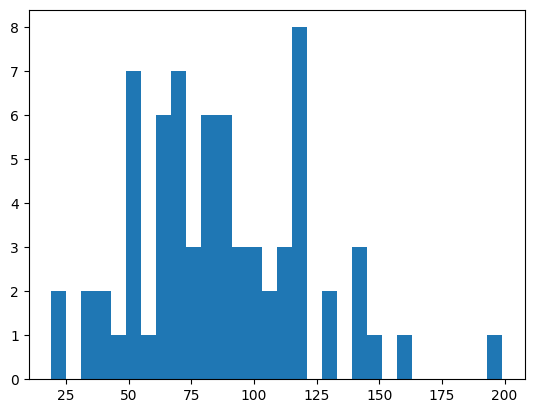

In [ ]:
import matplotlib.pyplot as plt

lens = [len(x.split()) for x in df1['줄거리']]

plt.hist(lens, bins=30)
plt.show()

### 장르 + 줄거리

In [ ]:
from sentence_transformers import SentenceTransformer, util

embedder = SentenceTransformer('jhgan/ko-sroberta-multitask')
embedder.max_seq_len = 128

In [ ]:
titles = df_data['Title'].tolist()
stories = df_data['genres_keywords'].tolist()

# Fit model to corpus qnd push to GPU
story_embeddings = embedder.encode(stories, convert_to_tensor=True)

In [ ]:
def semantic_search(input_data):
  title_list = []
  story_list = []
  score_list = []

  results = pd.DataFrame()
  # Find the closest 5 stories of the corpus for each query sentence based on cosine similarity
  top_k = min(6, len(story_embeddings))

  # input_data가 20자 이하이고 없을 경우
  if len(input_data) < 20 and input_data not in titles:
    print('Title Not Found')

  # If input is in the dataset
  elif input_data in titles:
    query_embeddings = embedder.encode(str(df_data[df_data['Title'] == input_data]['genres_keywords'])[5:-33], convert_to_tensor=True)

    # Use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.pytorch_cos_sim(query_embeddings, story_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    input_data_2 = input_data.replace('.', '.\n')
    print("\n\n======================")
    print("    TOP RESULTS")
    print("======================\n")

    # For score, index in torch.topk(cos_scores, k=top_k) use index  locator for feature lists
    # push score to cpu and convert to 1D array
    for score, idx in zip(top_results[0], top_results[1]):
      title_list.append(titles[idx])
      story_list.append(stories[idx])
      score_list.append(score.cpu().numpy().flatten())

    results['Title'] = title_list
    results['Story'] = story_list
    results['Score'] = score_list
    return results.iloc[1:, :]

  # input_data가 20자 이상이고 없을 경우
  elif len(input_data) > 20 and input_data not in titles:
    # Find the closest 5 stories of the corpus for each query sentence based on cosine similarity
    query_embeddings = embedder.encode(input_data, convert_to_tensor=True)

    # Use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.pytorch_cos_sim(query_embeddings, story_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    input_data = input_data.replace('.', '.\n')
    print(input_data)
    print("\n\n======================")
    print("    TOP RESULTS")
    print("======================\n")

    # For score, index in torch.topk(cos_scores, k=top_k) use index  locator for feature lists
    # push score to cpu and convert to 1D array
    for score, idx in zip(top_results[0], top_results[1]):
      title_list.append(titles[idx])
      story_list.append(stories[idx])
      score_list.append(score.cpu().numpy().flatten())

    # Push results to dictionary columns
    results['Title'] = title_list
    results['Story'] = story_list
    results['Score'] = score_list
    return results

In [ ]:
semantic_search('뮤지컬 〈삼총사〉')



    TOP RESULTS



,Title,Story,Score
1,뮤지컬 〈렛미플라이〉,역사극 드라마 아폴로 호가 달을 향해 쏘아 올려진 년의 밤\n동네 최고의 수선장이...,[0.4832156]
2,뮤지컬 〈마리 퀴리〉,드라마 역사극 죽음을 앞둔 마리 딸 이렌에게 세상에 남길 마지막 종이를 건네고 이...,[0.45620117]
3,뮤지컬 〈판〉,코믹 블랙코미디 감동 세기 말 조선 서민들 사이에서 흉흉한 세상을 풍자하는 패관...,[0.45361242]
4,뮤지컬 〈22년 2개월〉,로맨스 역사극 년 혼란스러운 조선을 떠나 동경으로 가는 배 안\n쫓기던 박열은 도...,[0.3920949]
5,［Play＆Stay］태양의 서커스 〈루치아〉 x 도미인 강남,판타지 액션 노란마리골드 꽃밭에 추락한 낙하산\n호기심에 거대한 금속 열쇠를 돌리...,[0.39046752]


In [ ]:
semantic_search('뮤지컬 〈쇼맨_어느 독재자의 네 번째 대역배우〉')



    TOP RESULTS



,Title,Story,Score
1,［뮤지컬 on stage］ 뮤지컬 〈쇼맨 : 어느 독재자의 네 번째 대역배우〉 - 화성,드라마 공감/힐링 내가 가장 나다울 수 있는 순간을 향해 이것은 쇼 한바탕 꿈\n...,[0.5414222]
2,뮤지컬 〈쇼맨_어느 독재자의 네 번째 대역배우〉,드라마 공감/힐링 내가 가장 나다울 수 있는 순간을 향해 이것은 쇼 한바탕 꿈\n...,[0.5414222]
3,더 맨 얼라이브 〈초이스〉,코믹 성인용 지루한 일상을 날려버릴 진짜 남자들의 무대\n쇼 뮤지컬 THE MAN...,[0.48877466]
4,뮤지컬 〈인사이드 윌리엄〉 2023,드라마 공감/힐링 세계적인 명작 탄생을 꿈꾸며 명작 이대로만 하면 쓸 수 있다의 ...,[0.4717521]
5,뮤지컬 〈렌트〉,드라마 로맨스 공감/힐링 년 만에 크리스마스 시즌을 맞아 다시 돌아오다 지난 시...,[0.4542692]


In [ ]:
semantic_search('2023 창작뮤지컬어워드 NEXT')



    TOP RESULTS



,Title,Story,Score
1,런던레코드,드라마 감동 런던 외곽에 위치한 낡고 오래된 레코드 샵 주인 존은 오늘도 하루를 ...,[0.35344455]
2,뮤지컬 〈판〉,코믹 블랙코미디 감동 세기 말 조선 서민들 사이에서 흉흉한 세상을 풍자하는 패관...,[0.3386835]
3,동구문화체육센터 뮤지컬 〈앤 ANNE〉 - 인천,드라마 감동 오늘은 걸판여고 연극반이 공연할 작품 제목을 발표하는 날이다 저마다 ...,[0.28577393]
4,뮤지컬 〈빨래〉,드라마 감동 공감/힐링 서울살이 년 차인 나영과 솔롱고 작가의 꿈을 안고 서울에...,[0.259372]
5,뮤지컬 〈빨래〉 - 대구,드라마 감동 공감/힐링 서울살이 년 차인 나영과 솔롱고 작가의 꿈을 안고 서울에...,[0.259372]


##### 입력데이터랑 장르가 같으면 -> 줄거리끼리 코사인 유사도

In [ ]:
df1.head(3)

,Title,줄거리,장르
0,"2023 〈스웨그에이지 : 외쳐, 조선〉 - 인천",시조가 국가이념인 상상 속의 조선\n삶의 고단함과 역경을 시조 속에 담아 훌훌 털어...,역사극 판타지
1,2023 이은결 더 일루션 마스터피스 - 이천,THE ILLUSION은 단순히 여러 다양한 마술들을 나열하며 보여주는 기존의 매직...,마술 판타지
2,2023 창작뮤지컬어워드 NEXT,헌책방을 운영하는 에이미는 여느 날과 다름없이 책들에게 인사를 건네며 하루를 시작한...,드라마


In [ ]:
def recommend_similar_titles(input_title, df1, embedder, top_k=5):
    input_genre = df1[df1['Title'] == input_title]['장르'].values[0]

    # 입력 데이터의 SBERT 임베딩 생성
    input_story = df1[df1['Title'] == input_title]['줄거리'].values[0]
    input_embedding = embedder.encode(input_story, convert_to_tensor=True)

    # 장르가 겹치는 title만 필터링
    filtered_df = df1[df1['장르'].apply(lambda x: any(genre in input_genre for genre in x.split()))]

    # SBERT를 사용하여 유사도 계산
    story_embeddings = embedder.encode(filtered_df['줄거리'].tolist(), convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(input_embedding, story_embeddings)

    top_results = torch.topk(cos_scores, k=top_k)
    results = pd.DataFrame(columns=['Title', 'Genre', 'Score'])

    for score, idx in zip(top_results[0][0], top_results[1][0]):
        idx = idx.item()
        title = filtered_df.iloc[idx]['Title']
        genre = filtered_df.iloc[idx]['장르']
        results = results.append({'Title': title, 'Genre': genre, 'Score': score.item()}, ignore_index=True)

    return results

In [ ]:
input_title = '뮤지컬 〈쇼맨_어느 독재자의 네 번째 대역배우〉'
embedder = SentenceTransformer('jhgan/ko-sroberta-multitask')
recommended_titles = recommend_similar_titles(input_title, df1, embedder)
print(recommended_titles)

                                              Title       Genre     Score
0  ［뮤지컬 on stage］ 뮤지컬 〈쇼맨 : 어느 독재자의 네 번째 대역배우〉 - 화성  드라마  공감/힐링  1.000000
1                        뮤지컬 〈쇼맨_어느 독재자의 네 번째 대역배우〉  드라마  공감/힐링  1.000000
2                                       뮤지컬 〈렛미플라이〉    역사극  드라마  0.507207
3                                           라면에 파송송  코미디  공감/힐링  0.474386
4                                          뮤지컬 〈칠칠〉  드라마  공감/힐링  0.438743


<ipython-input-54-4fa6faf0201d>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Title': title, 'Genre': genre, 'Score': score.item()}, ignore_index=True)
<ipython-input-54-4fa6faf0201d>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Title': title, 'Genre': genre, 'Score': score.item()}, ignore_index=True)
<ipython-input-54-4fa6faf0201d>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Title': title, 'Genre': genre, 'Score': score.item()}, ignore_index=True)
<ipython-input-54-4fa6faf0201d>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = res